In [530]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import random
from tqdm import tqdm

In [531]:
seed = 1
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [532]:
# data prep
def gaussian_noise():
    return np.random.normal()


def ar_data_generator(init_seq, weights, noise_func, steps=500, normalize=True):
    """Generate AR(n) simulation data.

    Args:
        init_seq (np.array): Initial values to start with. An AR(n) process should have n initial values.
        weights (np.array): Weights on each prev time step and the noise term.
        noise_func (func): Calling this noise function gives a random term.
        steps (int): Length of the generated sequence.
    """
    init_steps = len(init_seq)
    sim_data = np.zeros(steps + init_steps)
    sim_data[:init_steps] = init_seq
    for i in range(steps):
        cur_val = 0
        for j in range(init_steps):
            cur_val += weights[j] * sim_data[i+j]
        cur_val += weights[-1] * noise_func()
        sim_data[i+init_steps] = cur_val
    sim_data = sim_data[init_steps:]
    if normalize:
        sim_data = (sim_data - np.mean(sim_data)) / np.std(sim_data)
    return sim_data


class SeqData(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.X[idx, :], self.y[idx])


def prepare_ts_ds(data, window_size, target_idx, train_size, val_size, test_size, batch_size):
    """Generate a time series dataset from simulation data.

    Args:
        data (np.array): Possible with F time series data of length N, in the shape of (N, F)
        target_idx (int): The index of the feature to be predicted.
        window_size (int)
        train_size (int)
        val_size (int)
        test_size (int)
    """
    data_len = len(data)
    train_xs, train_ys, test_xs, test_ys = [], [], [], []
    cur_test_num = 0
    for i in range(data_len):
        if i >= window_size:
            if i < (train_size + val_size) * 1.5:
                train_xs.append(data[i-window_size:i, :])
                train_ys.append(data[i, target_idx])
            elif cur_test_num < test_size:
                cur_test_num += 1
                test_xs.append(data[i-window_size:i, :])
                test_ys.append(data[i, target_idx])
            else:
                break
    train_xs = np.array(train_xs, dtype=np.float32)
    train_ys = np.array(train_ys, dtype=np.float32)
    test_xs = np.array(test_xs, dtype=np.float32)
    test_ys = np.array(test_ys, dtype=np.float32)
    dataset = SeqData(X=train_xs, y=train_ys)
    test_dataset = SeqData(X=test_xs, y=test_ys)
    train_dataset, val_dataset, _ = torch.utils.data.random_split(dataset, [train_size, val_size, len(dataset)-train_size-val_size])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size ,shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader, test_dataloader

[2.61624345 2.62525285 2.65564397 ... 3.34859454 3.35102954 3.33709735]


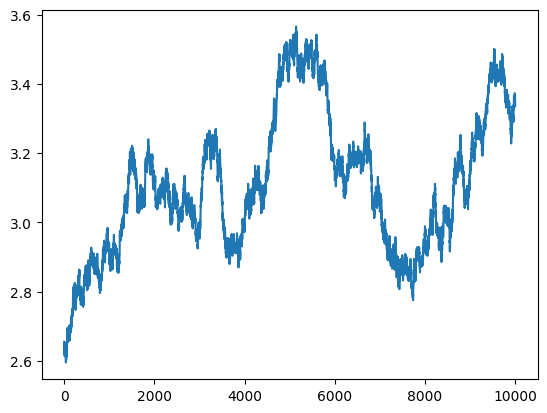

In [533]:
# simulation data
init_seq = np.array([1, 2, 3])
weights = np.array([0.1, 0.2, 0.7, 0.01])
noise_func = gaussian_noise
steps = 10000
sim_data = ar_data_generator(init_seq, weights, noise_func, steps, normalize=False)
data = sim_data[100:, None]
print(sim_data)
plt.plot(sim_data[:])
plt.show()

# dataloader
train_dl, val_dl, test_dl = prepare_ts_ds(data, 3, 0, 2000, 500, 1000, 32)

In [534]:
# models
class FF(nn.Module):
    def __init__(self, input_dim, seq_length, hidden_dim):
        super(FF, self).__init__()
        self.fc1 = nn.Linear(input_dim*seq_length, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # (batch size x seq length x input dim)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x[:, 0]


class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.output_dim = output_dim
        self.rnn = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.0,
            batch_first=True,
        )
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.rnn(x)[0]
        x = x[:, -1, :]
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x[:, 0]


# def Transformer():
#     def __init__(self, input_dim, hidden_dim, num_layers, num_heads):
#         super(TransformerEncoder, self).__init__()
#         self.embedding = nn.Linear(input_dim, hidden_dim)
#         self.encoder_layers = nn.TransformerEncoderLayer(hidden_dim, num_heads)
#         self.encoder = nn.TransformerEncoder(self.encoder_layers, num_layers)

#     def forward(self, x):
#         x = self.embedding(x)
#         x = self.temporal_conv(x)
#         x = x.permute(1, 0, 2)
#         x = self.pos_encoder(x)
#         encoder_output = self.encoder(x)
#         return encoder_output.permute(1, 0, 2)


# class RNNDecoder(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
#         """output dim is not actually the output dim. It is hidden dim 2."""
#         super(RNNDecoder, self).__init__()
#         self.output_dim = output_dim
#         self.rnn = nn.GRU(
#             input_size=input_dim,
#             hidden_size=hidden_dim,
#             num_layers=num_layers,
#             dropout=0.3,
#             batch_first=True,
#         )
#         self.fc1 = nn.Linear(hidden_dim, 1)
#         self.fc2 = nn.Linear(output_dim, hidden_dim)

#     def forward(self, encoder_output):
#         decoder_output = self.rnn(encoder_output)[0]
#         # print(decoder_output.shape)
#         decoder_output = decoder_output[:, -self.output_dim:, :]
#         decoder_output = self.fc1(decoder_output)
#         decoder_output = decoder_output[:, :, 0]
#         decoder_output = self.fc2(decoder_output)
#         return decoder_output


def perfect_model(x, weights):
    """
    x is in the shape of (batch size x seq length x input dim)
    """
    x = x[:, :, 0]
    res = []
    for b in range(x.shape[0]):
        cur_res = 0
        for i in range(len(weights)-1):
            cur_res += x[b, i] * weights[i]
        res.append(cur_res)
    return torch.tensor(res)

In [535]:
# model = FF(1, 3, 64)
model = RNN(1, 64, 4, 1)
learning_rate = 2e-5
device = torch.device('cuda:0')
epochs = 400

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.L1Loss()

for epoch in tqdm(range(epochs)):
    model.train()
    losses = []
    for batch in train_dl:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        # print(y_pred)
        # print(y)
        loss = loss_fn(y, y_pred)
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1, error_if_nonfinite=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    # print(f'loss is {np.mean(losses)}')
    model.eval()
    val_losses = []
    plosses = []
    for batch in test_dl:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        # print(y.shape)
        y_pred = model(x)
        # print(y_pred.shape)
        loss = loss_fn(y, y_pred)
        val_losses.append(loss.detach().cpu().numpy())
        py_pred = perfect_model(x, weights).to(device)
        ploss = loss_fn(y, py_pred)
        plosses.append(ploss.detach().cpu().numpy())
    # print(f'val loss is {np.mean(val_losses)}, perfect loss: {np.mean(plosses)}')

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:51<00:00,  3.86it/s]


0.00024512692


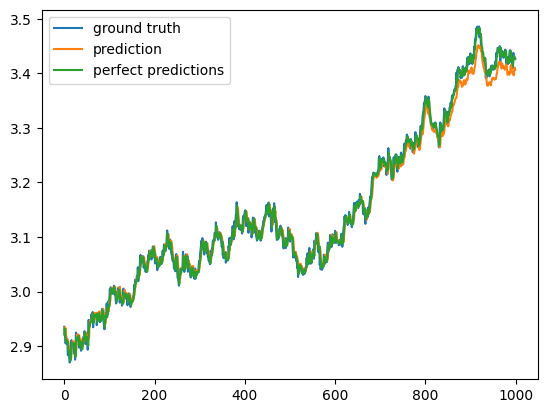

In [536]:
# test
model.eval()
tys = []
pys = []
perfect_pys = []
for batch in test_dl:
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    py_pred = perfect_model(x, weights).to(device)
    # save
    y_pred = y_pred.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    py_pred = py_pred.detach().cpu().numpy()
    for i in range(len(y)):
        tys.append(y[i])
        pys.append(y_pred[i])
        perfect_pys.append(py_pred[i])
tys = np.array(tys)
pys = np.array(pys)
mse = np.mean((tys - pys)**2)
print(mse)
plt.plot(tys, label='ground truth')
plt.plot(pys, label='prediction')
plt.plot(perfect_pys, label='perfect predictions')
plt.legend()
plt.show()